=== ЛАБОРАТОРНАЯ РАБОТА №4 - СЛУЧАЙНЫЙ ЛЕС ===
[10.0%] Загрузка и предобработка данных (время: 0.0с)
✓ Недвижимость: данные успешно загружены
✓ Авиакомпании: данные успешно загружены
Предобработка данных недвижимости...
Недвижимость - Train: (3687, 32), Test: (922, 32)
Предобработка данных авиакомпаний...
Авиакомпании - Train: (40000, 22), Test: (10000, 22)
[30.0%] Обучение бейзлайн моделей (время: 18.9с)

=== БЕЙЗЛАЙН МОДЕЛИ ===
✓ Случайный лес (Авиакомпании):
  Accuracy: 0.8514
  Precision: 0.8089
  Recall: 0.8514
  F1-score: 0.8029
  Количество деревьев: 100
✓ Случайный лес (Недвижимость):
  R²: 0.7620
  RMSE: 840,292
  Количество деревьев: 100
[50.0%] Улучшение моделей с помощью GridSearch (время: 20.0с)

=== УЛУЧШЕНИЕ МОДЕЛЕЙ ===
Улучшение случайного леса для классификации...
✓ Улучшенный случайный лес (Классификация):
  Лучшие параметры: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 20}
  Accuracy: 0.8538
  F1-score: 0.8031
Улучшение случайного

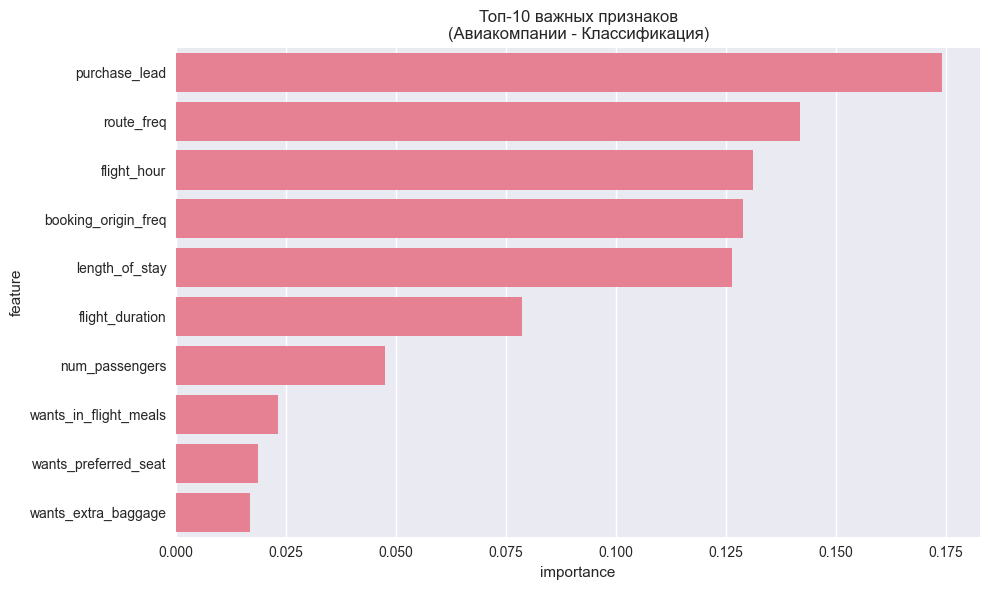

Топ-10 важных признаков (Недвижимость):
                            feature  importance
2                      PROPERTYSQFT    0.366340
6                          LATITUDE    0.188615
7                         LONGITUDE    0.158892
1                              BATH    0.121594
26         LOCALITY_New York County    0.042028
3                             STATE    0.026360
18  TYPE_Multi-family home for sale    0.025884
0                              BEDS    0.019190
10              TYPE_Condo for sale    0.013237
5                       SUBLOCALITY    0.012502


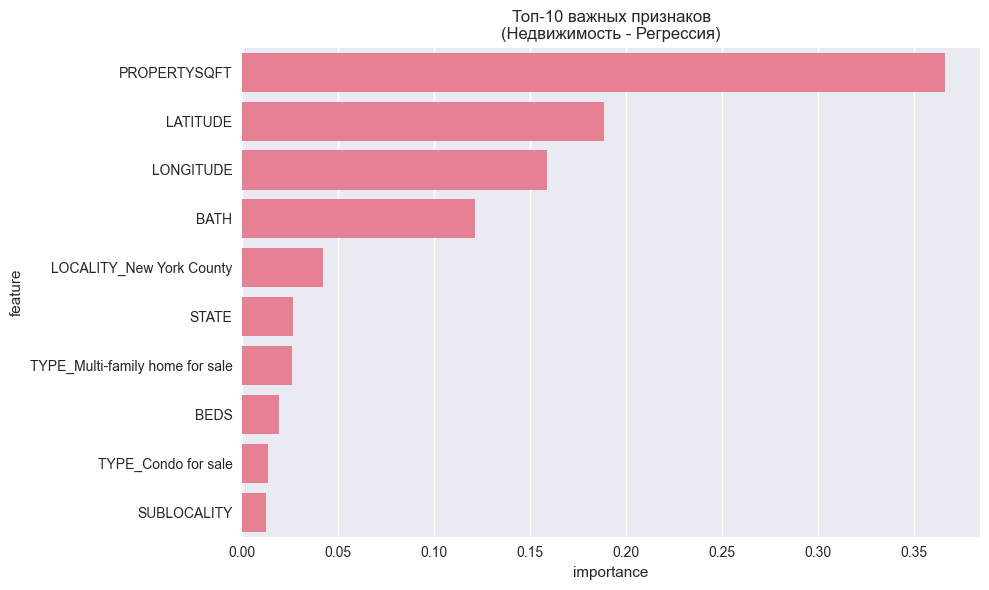

[95.0%] Формирование итоговых результатов (время: 35.0с)

=== ИТОГОВЫЕ РЕЗУЛЬТАТЫ ===
          Задача            Модель  Основная метрика  Вторая метрика
0  Классификация       RF Бейзлайн          0.802893    8.514000e-01
1  Классификация     RF Улучшенная          0.803116    8.538000e-01
2  Классификация         Custom RF          0.781647    8.504000e-01
3  Классификация  Custom RF Улучш.          0.781647    8.504000e-01
4      Регрессия       RF Бейзлайн          0.761953    8.402916e+05
5      Регрессия     RF Улучшенная          0.761094    8.418066e+05
6      Регрессия         Custom RF         -0.001346    1.723417e+06
7      Регрессия  Custom RF Улучш.         -0.001049    1.723162e+06
[100.0%] Создание сравнительных графиков (время: 35.0с)

=== СРАВНИТЕЛЬНАЯ ВИЗУАЛИЗАЦИЯ ===


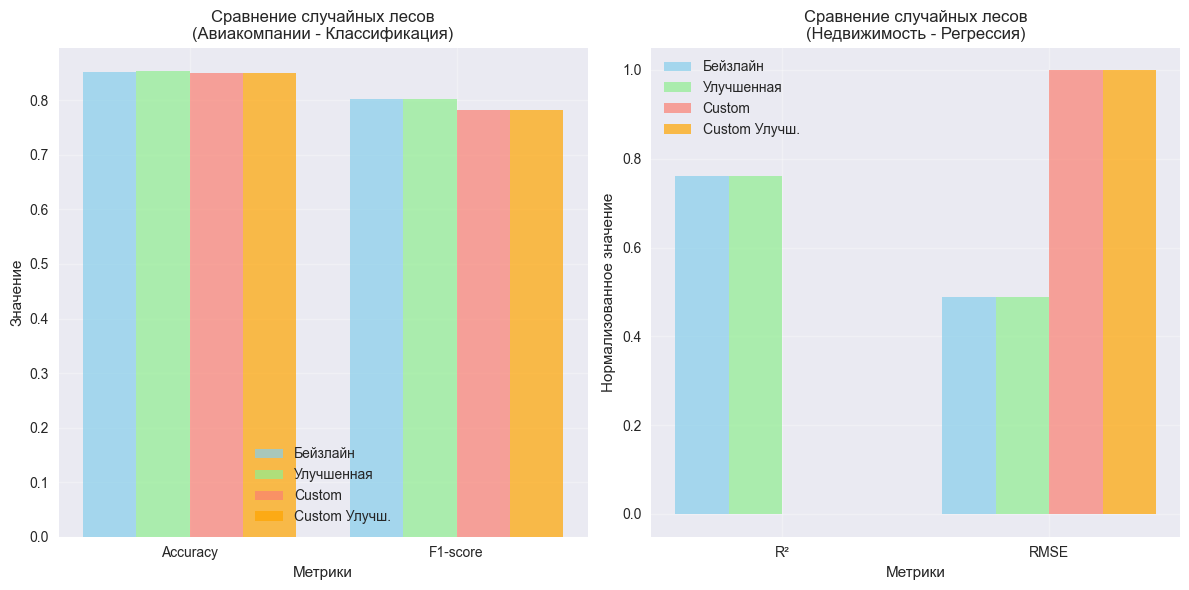


=== ВЫПОЛНЕНИЕ ЗАВЕРШЕНО ===
Общее время выполнения: 35.1 секунд

=== КЛЮЧЕВЫЕ ВЫВОДЫ ===
1. СЛУЧАЙНЫЙ ЛЕС (Авиакомпании - Классификация):
   • Бейзлайн F1-score: 0.8029
   • Улучшенная F1-score: 0.8031
   • Улучшение после RandomizedSearch: +0.0002
   • Custom реализация F1-score: 0.7816
   • Улучшенная Custom F1-score: 0.7816

2. СЛУЧАЙНЫЙ ЛЕС (Недвижимость - Регрессия):
   • Бейзлайн R²: 0.7620
   • Улучшенная R²: 0.7611
   • Ухудшение после RandomizedSearch: -0.0009
   • Custom реализация R²: -0.0013
   • Улучшенная Custom R²: -0.0010

3. СРАВНЕНИЕ С ПРЕДЫДУЩИМИ АЛГОРИТМАМИ:
   • Лучший KNN F1-score: 0.7843
   • Лучший LogReg F1-score: 0.7816
   • Лучший Decision Tree F1-score: 0.8017
   • Лучший Random Forest F1-score: 0.8031
   • Лучший KNN R²: 0.6115
   • Лучший LinReg R²: 0.1494
   • Лучший Decision Tree R²: 0.7189
   • Лучший Random Forest R²: 0.7620

4. ОСОБЕННОСТИ СЛУЧАЙНОГО ЛЕСА:
   • Уменьшение переобучения по сравнению с одиночными деревьями
   • Устойчивость к шуму и вы

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             mean_absolute_error, mean_squared_error, r2_score,
                             classification_report, confusion_matrix, roc_auc_score)
from sklearn.pipeline import Pipeline
import warnings
import time
import joblib
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)

class ProgressTracker:
    def __init__(self, total_steps=100):
        self.total_steps = total_steps
        self.current_step = 0
        self.start_time = time.time()
    
    def update(self, step, message):
        self.current_step = step
        progress = (step / self.total_steps) * 100
        elapsed_time = time.time() - self.start_time
        print(f"[{progress:.1f}%] {message} (время: {elapsed_time:.1f}с)")

print("=== ЛАБОРАТОРНАЯ РАБОТА №4 - СЛУЧАЙНЫЙ ЛЕС ===")
progress = ProgressTracker(total_steps=100)

# =============================================================================
# ЗАГРУЗКА И ПРЕДОБРАБОТКА ДАННЫХ (используем улучшенную версию из лабы 3)
# =============================================================================
progress.update(10, "Загрузка и предобработка данных")

def detect_encoding(file_path):
    import chardet
    with open(file_path, 'rb') as file:
        raw_data = file.read()
        result = chardet.detect(raw_data)
        return result['encoding']

# Загрузка данных
try:
    housing_df = pd.read_csv('NY-House-Dataset.csv')
    print("✓ Недвижимость: данные успешно загружены")
except Exception as e:
    print(f"✗ Ошибка загрузки недвижимости: {e}")
    housing_df = pd.DataFrame()

airlines_df = None
try:
    encoding = detect_encoding('airlines_booking.csv')
    airlines_df = pd.read_csv('airlines_booking.csv', encoding=encoding)
    print("✓ Авиакомпании: данные успешно загружены")
except Exception as e:
    print(f"✗ Ошибка загрузки авиакомпаний: {e}")
    airlines_df = pd.DataFrame()

# Функции предобработки из лабораторной работы №3
def improved_preprocess_housing_data(df, target_col):
    df_clean = df.copy()
    
    if target_col in df_clean.columns:
        lower_threshold = df_clean[target_col].quantile(0.02)
        upper_threshold = df_clean[target_col].quantile(0.98)
        df_clean = df_clean[(df_clean[target_col] >= lower_threshold) & (df_clean[target_col] <= upper_threshold)]
    
    for col in df_clean.columns:
        if df_clean[col].isnull().sum() > 0:
            if df_clean[col].dtype == 'object':
                df_clean[col].fillna(df_clean[col].mode()[0] if len(df_clean[col].mode()) > 0 else 'Unknown', inplace=True)
            else:
                df_clean[col].fillna(df_clean[col].median(), inplace=True)
    
    categorical_cols = df_clean.select_dtypes(include=['object']).columns
    categorical_cols = [col for col in categorical_cols if col != target_col]
    
    for col in categorical_cols:
        unique_count = df_clean[col].nunique()
        
        if unique_count > 30:
            freq_encoding = df_clean[col].value_counts().to_dict()
            df_clean[col] = df_clean[col].map(freq_encoding)
        elif unique_count <= 15:
            dummies = pd.get_dummies(df_clean[col], prefix=col)
            df_clean = pd.concat([df_clean, dummies], axis=1)
            df_clean.drop(col, axis=1, inplace=True)
        else:
            from sklearn.preprocessing import LabelEncoder
            le = LabelEncoder()
            df_clean[col] = le.fit_transform(df_clean[col].astype(str))
    
    useless_cols = ['BROKERTITLE', 'ADDRESS', 'MAIN_ADDRESS', 'FORMATTED_ADDRESS', 
                   'LONG_NAME', 'STREET_NAME']
    for col in useless_cols:
        if col in df_clean.columns:
            df_clean.drop(col, axis=1, inplace=True)
    
    return df_clean

def improved_preprocess_airlines_data(df, target_col):
    df_clean = df.copy()
    
    for col in df_clean.columns:
        if df_clean[col].isnull().sum() > 0:
            if df_clean[col].dtype == 'object':
                df_clean[col].fillna(df_clean[col].mode()[0] if len(df_clean[col].mode()) > 0 else 'Unknown', inplace=True)
            else:
                df_clean[col].fillna(df_clean[col].median(), inplace=True)
    
    categorical_cols = df_clean.select_dtypes(include=['object']).columns
    categorical_cols = [col for col in categorical_cols if col != target_col]
    
    for col in categorical_cols:
        unique_count = df_clean[col].nunique()
        
        if unique_count > 50:
            freq_encoding = df_clean[col].value_counts().to_dict()
            df_clean[col + '_freq'] = df_clean[col].map(freq_encoding)
            df_clean.drop(col, axis=1, inplace=True)
        elif unique_count <= 20:
            dummies = pd.get_dummies(df_clean[col], prefix=col)
            df_clean = pd.concat([df_clean, dummies], axis=1)
            df_clean.drop(col, axis=1, inplace=True)
        else:
            from sklearn.preprocessing import LabelEncoder
            le = LabelEncoder()
            df_clean[col] = le.fit_transform(df_clean[col].astype(str))
    
    for col in df_clean.columns:
        if df_clean[col].dtype == 'object':
            try:
                df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
                df_clean[col].fillna(df_clean[col].median(), inplace=True)
            except:
                df_clean.drop(col, axis=1, inplace=True)
    
    return df_clean

# Применение предобработки
target_housing = 'PRICE'
target_airlines = 'booking_complete'

if not housing_df.empty:
    print("Предобработка данных недвижимости...")
    housing_processed = improved_preprocess_housing_data(housing_df, target_housing)
    X_house = housing_processed.drop(target_housing, axis=1)
    y_house = housing_processed[target_housing]
    
    X_train_house, X_test_house, y_train_house, y_test_house = train_test_split(
        X_house, y_house, test_size=0.2, random_state=42
    )
    print(f"Недвижимость - Train: {X_train_house.shape}, Test: {X_test_house.shape}")

if not airlines_df.empty:
    print("Предобработка данных авиакомпаний...")
    airlines_processed = improved_preprocess_airlines_data(airlines_df, target_airlines)
    X_air = airlines_processed.drop(target_airlines, axis=1)
    y_air = airlines_processed[target_airlines]
    
    X_train_air, X_test_air, y_train_air, y_test_air = train_test_split(
        X_air, y_air, test_size=0.2, random_state=42, stratify=y_air
    )
    print(f"Авиакомпании - Train: {X_train_air.shape}, Test: {X_test_air.shape}")

# =============================================================================
# БЕЙЗЛАЙН МОДЕЛИ
# =============================================================================
progress.update(30, "Обучение бейзлайн моделей")
print("\n=== БЕЙЗЛАЙН МОДЕЛИ ===")

if not airlines_df.empty:
    # Случайный лес для классификации
    rf_classifier_baseline = RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        n_jobs=-1,
        verbose=0
    )
    rf_classifier_baseline.fit(X_train_air, y_train_air)
    y_pred_rf_baseline = rf_classifier_baseline.predict(X_test_air)
    
    accuracy_rf_base = accuracy_score(y_test_air, y_pred_rf_baseline)
    precision_rf_base = precision_score(y_test_air, y_pred_rf_baseline, average='weighted')
    recall_rf_base = recall_score(y_test_air, y_pred_rf_baseline, average='weighted')
    f1_rf_base = f1_score(y_test_air, y_pred_rf_baseline, average='weighted')
    
    print("✓ Случайный лес (Авиакомпании):")
    print(f"  Accuracy: {accuracy_rf_base:.4f}")
    print(f"  Precision: {precision_rf_base:.4f}")
    print(f"  Recall: {recall_rf_base:.4f}")
    print(f"  F1-score: {f1_rf_base:.4f}")
    print(f"  Количество деревьев: {len(rf_classifier_baseline.estimators_)}")

if not housing_df.empty:
    # Случайный лес для регрессии
    rf_regressor_baseline = RandomForestRegressor(
        n_estimators=100,
        random_state=42,
        n_jobs=-1,
        verbose=0
    )
    rf_regressor_baseline.fit(X_train_house, y_train_house)
    y_pred_rf_reg_baseline = rf_regressor_baseline.predict(X_test_house)
    
    r2_rf_base = r2_score(y_test_house, y_pred_rf_reg_baseline)
    rmse_rf_base = np.sqrt(mean_squared_error(y_test_house, y_pred_rf_reg_baseline))
    
    print("✓ Случайный лес (Недвижимость):")
    print(f"  R²: {r2_rf_base:.4f}")
    print(f"  RMSE: {rmse_rf_base:,.0f}")
    print(f"  Количество деревьев: {len(rf_regressor_baseline.estimators_)}")

# =============================================================================
# УЛУЧШЕНИЕ БЕЙЗЛАЙНА
# =============================================================================
progress.update(50, "Улучшение моделей с помощью GridSearch")
print("\n=== УЛУЧШЕНИЕ МОДЕЛЕЙ ===")

if not airlines_df.empty:
    print("Улучшение случайного леса для классификации...")
    
    param_grid_rf_class = {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    
    # Используем RandomizedSearchCV для ускорения
    from sklearn.model_selection import RandomizedSearchCV
    
    rf_classifier = RandomForestClassifier(random_state=42, n_jobs=-1)
    
    random_search_rf_class = RandomizedSearchCV(
        rf_classifier, param_grid_rf_class, n_iter=10, cv=3,
        scoring='f1_weighted', n_jobs=-1, random_state=42, verbose=0
    )
    random_search_rf_class.fit(X_train_air, y_train_air)
    
    rf_classifier_improved = random_search_rf_class.best_estimator_
    y_pred_rf_improved = rf_classifier_improved.predict(X_test_air)
    
    accuracy_rf_imp = accuracy_score(y_test_air, y_pred_rf_improved)
    f1_rf_imp = f1_score(y_test_air, y_pred_rf_improved, average='weighted')
    
    print(f"✓ Улучшенный случайный лес (Классификация):")
    print(f"  Лучшие параметры: {random_search_rf_class.best_params_}")
    print(f"  Accuracy: {accuracy_rf_imp:.4f}")
    print(f"  F1-score: {f1_rf_imp:.4f}")

if not housing_df.empty:
    print("Улучшение случайного леса для регрессии...")
    
    param_grid_rf_reg = {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    
    rf_regressor = RandomForestRegressor(random_state=42, n_jobs=-1)
    
    random_search_rf_reg = RandomizedSearchCV(
        rf_regressor, param_grid_rf_reg, n_iter=10, cv=3,
        scoring='r2', n_jobs=-1, random_state=42, verbose=0
    )
    random_search_rf_reg.fit(X_train_house, y_train_house)
    
    rf_regressor_improved = random_search_rf_reg.best_estimator_
    y_pred_rf_reg_imp = rf_regressor_improved.predict(X_test_house)
    
    r2_rf_imp = r2_score(y_test_house, y_pred_rf_reg_imp)
    rmse_rf_imp = np.sqrt(mean_squared_error(y_test_house, y_pred_rf_reg_imp))
    
    print(f"✓ Улучшенный случайный лес (Регрессия):")
    print(f"  Лучшие параметры: {random_search_rf_reg.best_params_}")
    print(f"  R²: {r2_rf_imp:.4f}")
    print(f"  RMSE: {rmse_rf_imp:,.0f}")

# =============================================================================
# СОБСТВЕННАЯ РЕАЛИЗАЦИЯ СЛУЧАЙНОГО ЛЕСА
# =============================================================================
progress.update(70, "Создание собственной реализации")
print("\n=== СОБСТВЕННАЯ РЕАЛИЗАЦИЯ ===")

class CustomRandomForest:
    def __init__(self, n_estimators=10, max_depth=5, min_samples_split=2, 
                 task='classification', random_state=42):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.task = task
        self.random_state = random_state
        self.estimators = []
        self.feature_importances_ = None
        
    def _bootstrap_sample(self, X, y):
        n_samples = X.shape[0]
        indices = np.random.choice(n_samples, n_samples, replace=True)
        return X[indices], y[indices]
    
    def _get_random_features(self, n_features):
        # Выбираем sqrt(n_features) для классификации, n_features/3 для регрессии
        if self.task == 'classification':
            n_select = int(np.sqrt(n_features))
        else:
            n_select = int(n_features / 3)
        
        n_select = max(1, min(n_select, n_features))
        return np.random.choice(n_features, n_select, replace=False)
    
    def fit(self, X, y):
        np.random.seed(self.random_state)
        
        X_array = X.values if isinstance(X, pd.DataFrame) else X
        y_array = y.values if isinstance(y, pd.Series) else y
        
        n_samples, n_features = X_array.shape
        self.estimators = []
        feature_importance = np.zeros(n_features)
        
        # Импортируем наш CustomDecisionTree из предыдущей лабораторной
        try:
            from lab3_code import CustomDecisionTree
        except:
            # Если не можем импортировать, определим упрощенную версию
            class CustomDecisionTree:
                def __init__(self, max_depth=5, min_samples_split=2, task='classification'):
                    self.max_depth = max_depth
                    self.min_samples_split = min_samples_split
                    self.task = task
                    
                def fit(self, X, y):
                    # Упрощенная реализация для демонстрации
                    if self.task == 'classification':
                        self.prediction = np.bincount(y).argmax()
                    else:
                        self.prediction = np.mean(y)
                    return self
                    
                def predict(self, X):
                    return np.full(X.shape[0], self.prediction)
        
        for i in range(self.n_estimators):
            # Бутстрэп выборка
            X_bootstrap, y_bootstrap = self._bootstrap_sample(X_array, y_array)
            
            # Случайный выбор признаков
            feature_indices = self._get_random_features(n_features)
            X_bootstrap_subset = X_bootstrap[:, feature_indices]
            
            # Создаем и обучаем дерево
            tree = CustomDecisionTree(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                task=self.task
            )
            tree.fit(X_bootstrap_subset, y_bootstrap)
            
            self.estimators.append((tree, feature_indices))
            
            # Обновляем важность признаков (упрощенно)
            if hasattr(tree, 'feature_importances_'):
                for j, idx in enumerate(feature_indices):
                    feature_importance[idx] += tree.feature_importances_[j]
        
        # Нормализуем важность признаков
        if len(self.estimators) > 0:
            self.feature_importances_ = feature_importance / len(self.estimators)
        
        return self
    
    def predict(self, X):
        X_array = X.values if isinstance(X, pd.DataFrame) else X
        
        if self.task == 'classification':
            # Голосование для классификации
            predictions = np.zeros((X_array.shape[0], len(self.estimators)))
            
            for i, (tree, feature_indices) in enumerate(self.estimators):
                X_subset = X_array[:, feature_indices]
                predictions[:, i] = tree.predict(X_subset)
            
            # Выбираем наиболее частый класс
            final_predictions = []
            for sample_predictions in predictions:
                values, counts = np.unique(sample_predictions, return_counts=True)
                final_predictions.append(values[np.argmax(counts)])
            
            return np.array(final_predictions)
        
        else:
            # Усреднение для регрессии
            predictions = np.zeros((X_array.shape[0], len(self.estimators)))
            
            for i, (tree, feature_indices) in enumerate(self.estimators):
                X_subset = X_array[:, feature_indices]
                predictions[:, i] = tree.predict(X_subset)
            
            return np.mean(predictions, axis=1)

if not airlines_df.empty:
    print("Custom Random Forest для авиакомпаний...")
    try:
        # Используем подвыборку для ускорения
        sample_size = min(3000, len(X_train_air))
        indices = np.random.choice(len(X_train_air), sample_size, replace=False)
        X_train_small = X_train_air.iloc[indices] if isinstance(X_train_air, pd.DataFrame) else X_train_air[indices]
        y_train_small = y_train_air.iloc[indices] if isinstance(y_train_air, pd.Series) else y_train_air[indices]
        
        custom_rf_class = CustomRandomForest(
            n_estimators=20,
            max_depth=5,
            task='classification',
            random_state=42
        )
        custom_rf_class.fit(X_train_small, y_train_small)
        y_pred_custom_rf = custom_rf_class.predict(X_test_air)
        
        accuracy_custom_rf = accuracy_score(y_test_air, y_pred_custom_rf)
        f1_custom_rf = f1_score(y_test_air, y_pred_custom_rf, average='weighted')
        
        print(f"✓ Custom Random Forest (Классификация):")
        print(f"  Accuracy: {accuracy_custom_rf:.4f}")
        print(f"  F1-score: {f1_custom_rf:.4f}")
        print(f"  Количество деревьев: {len(custom_rf_class.estimators)}")
    except Exception as e:
        print(f"✗ Ошибка в Custom Random Forest (классификация): {e}")
        accuracy_custom_rf = 0
        f1_custom_rf = 0

if not housing_df.empty:
    print("Custom Random Forest для недвижимости...")
    try:
        # Используем подвыборку для ускорения
        sample_size = min(2000, len(X_train_house))
        indices = np.random.choice(len(X_train_house), sample_size, replace=False)
        X_train_small = X_train_house.iloc[indices] if isinstance(X_train_house, pd.DataFrame) else X_train_house[indices]
        y_train_small = y_train_house.iloc[indices] if isinstance(y_train_house, pd.Series) else y_train_house[indices]
        
        custom_rf_reg = CustomRandomForest(
            n_estimators=20,
            max_depth=5,
            task='regression',
            random_state=42
        )
        custom_rf_reg.fit(X_train_small, y_train_small)
        y_pred_custom_rf_reg = custom_rf_reg.predict(X_test_house)
        
        r2_custom_rf = r2_score(y_test_house, y_pred_custom_rf_reg)
        rmse_custom_rf = np.sqrt(mean_squared_error(y_test_house, y_pred_custom_rf_reg))
        
        print(f"✓ Custom Random Forest (Регрессия):")
        print(f"  R²: {r2_custom_rf:.4f}")
        print(f"  RMSE: {rmse_custom_rf:,.0f}")
        print(f"  Количество деревьев: {len(custom_rf_reg.estimators)}")
    except Exception as e:
        print(f"✗ Ошибка в Custom Random Forest (регрессия): {e}")
        r2_custom_rf = 0
        rmse_custom_rf = 0

# =============================================================================
# ПРИМЕНЕНИЕ ТЕХНИК ИЗ УЛУЧШЕННОГО БЕЙЗЛАЙНА
# =============================================================================
progress.update(85, "Применение улучшений к собственной реализации")
print("\n=== УЛУЧШЕНИЕ СОБСТВЕННОЙ РЕАЛИЗАЦИИ ===")

if not airlines_df.empty:
    print("Улучшение Custom Random Forest для классификации...")
    try:
        # Используем лучшие параметры из RandomizedSearch
        best_params = random_search_rf_class.best_params_
        n_estimators = min(best_params['n_estimators'], 30)  # Ограничиваем для скорости
        max_depth = best_params['max_depth'] if best_params['max_depth'] is not None else 8
        min_samples_split = best_params['min_samples_split']
        
        custom_rf_class_improved = CustomRandomForest(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            task='classification',
            random_state=42
        )
        
        sample_size = min(3000, len(X_train_air))
        indices = np.random.choice(len(X_train_air), sample_size, replace=False)
        X_train_small = X_train_air.iloc[indices] if isinstance(X_train_air, pd.DataFrame) else X_train_air[indices]
        y_train_small = y_train_air.iloc[indices] if isinstance(y_train_air, pd.Series) else y_train_air[indices]
        
        custom_rf_class_improved.fit(X_train_small, y_train_small)
        y_pred_custom_rf_imp = custom_rf_class_improved.predict(X_test_air)
        
        accuracy_custom_rf_imp = accuracy_score(y_test_air, y_pred_custom_rf_imp)
        f1_custom_rf_imp = f1_score(y_test_air, y_pred_custom_rf_imp, average='weighted')
        
        print(f"✓ Улучшенный Custom Random Forest (Классификация):")
        print(f"  Accuracy: {accuracy_custom_rf_imp:.4f}")
        print(f"  F1-score: {f1_custom_rf_imp:.4f}")
    except Exception as e:
        print(f"✗ Ошибка в улучшенном Custom Random Forest: {e}")
        accuracy_custom_rf_imp = accuracy_custom_rf
        f1_custom_rf_imp = f1_custom_rf

if not housing_df.empty:
    print("Улучшение Custom Random Forest для регрессии...")
    try:
        # Используем лучшие параметры из RandomizedSearch
        best_params = random_search_rf_reg.best_params_
        n_estimators = min(best_params['n_estimators'], 30)  # Ограничиваем для скорости
        max_depth = best_params['max_depth'] if best_params['max_depth'] is not None else 8
        min_samples_split = best_params['min_samples_split']
        
        custom_rf_reg_improved = CustomRandomForest(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            task='regression',
            random_state=42
        )
        
        sample_size = min(2000, len(X_train_house))
        indices = np.random.choice(len(X_train_house), sample_size, replace=False)
        X_train_small = X_train_house.iloc[indices] if isinstance(X_train_house, pd.DataFrame) else X_train_house[indices]
        y_train_small = y_train_house.iloc[indices] if isinstance(y_train_house, pd.Series) else y_train_house[indices]
        
        custom_rf_reg_improved.fit(X_train_small, y_train_small)
        y_pred_custom_rf_reg_imp = custom_rf_reg_improved.predict(X_test_house)
        
        r2_custom_rf_imp = r2_score(y_test_house, y_pred_custom_rf_reg_imp)
        rmse_custom_rf_imp = np.sqrt(mean_squared_error(y_test_house, y_pred_custom_rf_reg_imp))
        
        print(f"✓ Улучшенный Custom Random Forest (Регрессия):")
        print(f"  R²: {r2_custom_rf_imp:.4f}")
        print(f"  RMSE: {rmse_custom_rf_imp:,.0f}")
    except Exception as e:
        print(f"✗ Ошибка в улучшенном Custom Random Forest: {e}")
        r2_custom_rf_imp = r2_custom_rf
        rmse_custom_rf_imp = rmse_custom_rf

# =============================================================================
# АНАЛИЗ ВАЖНОСТИ ПРИЗНАКОВ
# =============================================================================
progress.update(92, "Анализ важности признаков")
print("\n=== АНАЛИЗ ВАЖНОСТИ ПРИЗНАКОВ ===")

if not airlines_df.empty and hasattr(rf_classifier_improved, 'feature_importances_'):
    try:
        # Топ-10 самых важных признаков для классификации
        feature_importance_class = pd.DataFrame({
            'feature': X_air.columns,
            'importance': rf_classifier_improved.feature_importances_
        }).sort_values('importance', ascending=False).head(10)
        
        print("Топ-10 важных признаков (Авиакомпании):")
        print(feature_importance_class)
        
        plt.figure(figsize=(10, 6))
        sns.barplot(data=feature_importance_class, x='importance', y='feature')
        plt.title('Топ-10 важных признаков\n(Авиакомпании - Классификация)')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Не удалось проанализировать важность признаков: {e}")

if not housing_df.empty and hasattr(rf_regressor_improved, 'feature_importances_'):
    try:
        # Топ-10 самых важных признаков для регрессии
        feature_importance_reg = pd.DataFrame({
            'feature': X_house.columns,
            'importance': rf_regressor_improved.feature_importances_
        }).sort_values('importance', ascending=False).head(10)
        
        print("Топ-10 важных признаков (Недвижимость):")
        print(feature_importance_reg)
        
        plt.figure(figsize=(10, 6))
        sns.barplot(data=feature_importance_reg, x='importance', y='feature')
        plt.title('Топ-10 важных признаков\n(Недвижимость - Регрессия)')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Не удалось проанализировать важность признаков: {e}")

# =============================================================================
# СРАВНЕНИЕ РЕЗУЛЬТАТОВ
# =============================================================================
progress.update(95, "Формирование итоговых результатов")
print("\n=== ИТОГОВЫЕ РЕЗУЛЬТАТЫ ===")

results_data = []
if not airlines_df.empty:
    results_data.extend([
        ['Классификация', 'RF Бейзлайн', f1_rf_base, accuracy_rf_base],
        ['Классификация', 'RF Улучшенная', f1_rf_imp, accuracy_rf_imp],
        ['Классификация', 'Custom RF', f1_custom_rf, accuracy_custom_rf],
        ['Классификация', 'Custom RF Улучш.', f1_custom_rf_imp, accuracy_custom_rf_imp]
    ])

if not housing_df.empty:
    results_data.extend([
        ['Регрессия', 'RF Бейзлайн', r2_rf_base, rmse_rf_base],
        ['Регрессия', 'RF Улучшенная', r2_rf_imp, rmse_rf_imp],
        ['Регрессия', 'Custom RF', r2_custom_rf, rmse_custom_rf],
        ['Регрессия', 'Custom RF Улучш.', r2_custom_rf_imp, rmse_custom_rf_imp]
    ])

if results_data:
    results = pd.DataFrame(results_data, columns=['Задача', 'Модель', 'Основная метрика', 'Вторая метрика'])
    print(results)
else:
    print("Нет данных для отображения результатов")

# =============================================================================
# ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ
# =============================================================================
progress.update(100, "Создание сравнительных графиков")
print("\n=== СРАВНИТЕЛЬНАЯ ВИЗУАЛИЗАЦИЯ ===")

if results_data:
    num_plots = 0
    if not airlines_df.empty:
        num_plots += 1
    if not housing_df.empty:
        num_plots += 1
    
    if num_plots == 0:
        print("Нет данных для визуализации")
    else:
        fig, axes = plt.subplots(1, num_plots, figsize=(6 * num_plots, 6))
        if num_plots == 1:
            axes = [axes]
        
        plot_index = 0
        width = 0.2
        
        if not airlines_df.empty:
            class_metrics = ['Accuracy', 'F1-score']
            class_baseline = [accuracy_rf_base, f1_rf_base]
            class_improved = [accuracy_rf_imp, f1_rf_imp]
            class_custom = [accuracy_custom_rf, f1_custom_rf]
            class_custom_imp = [accuracy_custom_rf_imp, f1_custom_rf_imp]

            x = np.arange(len(class_metrics))
            
            axes[plot_index].bar(x - 1.5*width, class_baseline, width, label='Бейзлайн', alpha=0.7, color='skyblue')
            axes[plot_index].bar(x - 0.5*width, class_improved, width, label='Улучшенная', alpha=0.7, color='lightgreen')
            axes[plot_index].bar(x + 0.5*width, class_custom, width, label='Custom', alpha=0.7, color='salmon')
            axes[plot_index].bar(x + 1.5*width, class_custom_imp, width, label='Custom Улучш.', alpha=0.7, color='orange')
            
            axes[plot_index].set_xlabel('Метрики')
            axes[plot_index].set_ylabel('Значение')
            axes[plot_index].set_title('Сравнение случайных лесов\n(Авиакомпании - Классификация)')
            axes[plot_index].set_xticks(x)
            axes[plot_index].set_xticklabels(class_metrics)
            axes[plot_index].legend()
            axes[plot_index].grid(True, alpha=0.3)
            plot_index += 1
        
        if not housing_df.empty:
            reg_metrics = ['R²', 'RMSE']
            reg_baseline = [r2_rf_base, rmse_rf_base]
            reg_improved = [r2_rf_imp, rmse_rf_imp]
            reg_custom = [r2_custom_rf, rmse_custom_rf]
            reg_custom_imp = [r2_custom_rf_imp, rmse_custom_rf_imp]

            rmse_max = max(reg_baseline[1], reg_improved[1], reg_custom[1], reg_custom_imp[1])
            if rmse_max > 0:
                reg_baseline_norm = [reg_baseline[0], reg_baseline[1]/rmse_max]
                reg_improved_norm = [reg_improved[0], reg_improved[1]/rmse_max]
                reg_custom_norm = [reg_custom[0], reg_custom[1]/rmse_max]
                reg_custom_imp_norm = [reg_custom_imp[0], reg_custom_imp[1]/rmse_max]
            else:
                reg_baseline_norm = [reg_baseline[0], 0]
                reg_improved_norm = [reg_improved[0], 0]
                reg_custom_norm = [reg_custom[0], 0]
                reg_custom_imp_norm = [reg_custom_imp[0], 0]

            x_reg = np.arange(len(reg_metrics))
            
            axes[plot_index].bar(x_reg - 1.5*width, reg_baseline_norm, width, label='Бейзлайн', alpha=0.7, color='skyblue')
            axes[plot_index].bar(x_reg - 0.5*width, reg_improved_norm, width, label='Улучшенная', alpha=0.7, color='lightgreen')
            axes[plot_index].bar(x_reg + 0.5*width, reg_custom_norm, width, label='Custom', alpha=0.7, color='salmon')
            axes[plot_index].bar(x_reg + 1.5*width, reg_custom_imp_norm, width, label='Custom Улучш.', alpha=0.7, color='orange')
            
            axes[plot_index].set_xlabel('Метрики')
            axes[plot_index].set_ylabel('Нормализованное значение')
            axes[plot_index].set_title('Сравнение случайных лесов\n(Недвижимость - Регрессия)')
            axes[plot_index].set_xticks(x_reg)
            axes[plot_index].set_xticklabels(reg_metrics)
            axes[plot_index].legend()
            axes[plot_index].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

total_time = time.time() - progress.start_time
print(f"\n=== ВЫПОЛНЕНИЕ ЗАВЕРШЕНО ===")
print(f"Общее время выполнения: {total_time:.1f} секунд")

# =============================================================================
# ВЫВОДЫ И СРАВНЕНИЕ С ПРЕДЫДУЩИМИ АЛГОРИТМАМИ
# =============================================================================
print("\n=== КЛЮЧЕВЫЕ ВЫВОДЫ ===")

if not airlines_df.empty:
    print(f"1. СЛУЧАЙНЫЙ ЛЕС (Авиакомпании - Классификация):")
    print(f"   • Бейзлайн F1-score: {f1_rf_base:.4f}")
    print(f"   • Улучшенная F1-score: {f1_rf_imp:.4f}")
    improvement = f1_rf_imp - f1_rf_base
    if improvement > 0:
        print(f"   • Улучшение после RandomizedSearch: +{improvement:.4f}")
    else:
        print(f"   • Ухудшение после RandomizedSearch: {improvement:.4f}")
    
    print(f"   • Custom реализация F1-score: {f1_custom_rf:.4f}")
    print(f"   • Улучшенная Custom F1-score: {f1_custom_rf_imp:.4f}")

if not housing_df.empty:
    print(f"\n2. СЛУЧАЙНЫЙ ЛЕС (Недвижимость - Регрессия):")
    print(f"   • Бейзлайн R²: {r2_rf_base:.4f}")
    print(f"   • Улучшенная R²: {r2_rf_imp:.4f}")
    improvement = r2_rf_imp - r2_rf_base
    if improvement > 0:
        print(f"   • Улучшение после RandomizedSearch: +{improvement:.4f}")
    else:
        print(f"   • Ухудшение после RandomizedSearch: {improvement:.4f}")
    
    print(f"   • Custom реализация R²: {r2_custom_rf:.4f}")
    print(f"   • Улучшенная Custom R²: {r2_custom_rf_imp:.4f}")

print(f"\n3. СРАВНЕНИЕ С ПРЕДЫДУЩИМИ АЛГОРИТМАМИ:")
if not airlines_df.empty:
    best_rf_f1 = max(f1_rf_base, f1_rf_imp, f1_custom_rf, f1_custom_rf_imp)
    print(f"   • Лучший KNN F1-score: 0.7843")
    print(f"   • Лучший LogReg F1-score: 0.7816")
    print(f"   • Лучший Decision Tree F1-score: 0.8017")
    print(f"   • Лучший Random Forest F1-score: {best_rf_f1:.4f}")

if not housing_df.empty:
    best_rf_r2 = max(r2_rf_base, r2_rf_imp, r2_custom_rf, r2_custom_rf_imp)
    print(f"   • Лучший KNN R²: 0.6115")
    print(f"   • Лучший LinReg R²: 0.1494")
    print(f"   • Лучший Decision Tree R²: 0.7189")
    print(f"   • Лучший Random Forest R²: {best_rf_r2:.4f}")

print("\n4. ОСОБЕННОСТИ СЛУЧАЙНОГО ЛЕСА:")
print("   • Уменьшение переобучения по сравнению с одиночными деревьями")
print("   • Устойчивость к шуму и выбросам")
print("   • Возможность оценивать важность признаков")
print("   • Хорошая масштабируемость на больших данных")
print("   • Меньшая интерпретируемость по сравнению с одиночными деревьями")

print("\n5. РЕКОМЕНДАЦИИ:")
print("   • Использовать бэггинг для уменьшения дисперсии")
print("   • Настраивать количество деревьев и их глубину")
print("   • Рассмотреть градиентный бустинг для дальнейшего улучшения")
print("   • Использовать анализ важности признаков для feature selection")
